In [1]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D
import nbimporter
import dynamicalModels as dynamicalModels
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

Importing Jupyter notebook from dynamicalModels.ipynb


# Embedding 

In [4]:
def make_manifold_point(X,E,tau,t):
    '''
    Creates point on a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        t: a time point between (E-1)*tau < t < L
    Returns:
        X[range_revered_iterable]: a point in R^E.
    '''
    
    L = X.shape[0]
    range_iterable = range(t-(E-1)*tau,t+tau,tau)
    range_revered_iterable = list(reversed(range_iterable))
    return X[range_revered_iterable]

def make_manifold(X,E,tau):
    '''
    Creates a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        
    Returns:
        embedding_x: a array of L - (E-1)*tau points
                    in R^E.
    '''
    
    # get length of time series
    L = X.shape[0]
    
    # initialize the embedding array matrix
    embedding_x =np.zeros((L - (E-1)*tau,E))
    
    i=0
    # create embedding matrix
    for t in range((E-1)*tau,L):
        # create a sequence of numbers between t-(E-1)*tau
        # and t+tau spaced by tau
    
        range_iterable = range(t-(E-1)*tau,t+tau,tau)
        
        #reverse the order of the sequence and coerce in a list
        range_revered_iterable = list(reversed(range_iterable))
        
        
        #put the entries of X at indices, range_revered_iterable,
        #in the ith row of embedding_x
        
        embedding_x[i,:] = X[range_revered_iterable]
        i+=1
    return embedding_x

def weight_function(distance):
    '''
    Exponentially weighted distance function
    
    Args:
        distance: a vector of distances
    Returns:
        u_i: normalized exponential weights
    '''
    
    non_indices=np.nonzero(distance)[0]
    if len(non_indices) == 0:
        norm_distance = 1
    else:
        norm_distance = distance[non_indices[0]]
    weighted_distance = np.exp(-distance/norm_distance)
    u_i = weighted_distance/np.sum(weighted_distance)
    return u_i


def generate_convergent_cross_approx(X,Y,E,tau):
    '''
    Approximates Y from X by 1) creating an embedding
    manifold of X, 2) mapping the neighbours of each point
    in the embedding manifold of X to the embedding manifold of 
    Y, 3) taking a exponetially weighted average of entries of 
    time series of Y associated the mapped neighbours.
    
    Args:
        X: time series used to estimate Y
        Y: time series to be estimated
        E: embedding dimension
        tau: time shift
        
    Returns:
        Y_approx: a L - (E-1)*tau time series appromixating
                  the last L - (E-1)*tau entries of Y.
    '''
    
    #makes X manifold

    xhat=make_manifold(X,E,tau)
    #number of time points to be approximated
    num_time_points = xhat.shape[0]
    
    #Initialized KNN object with xhat 
    nbrs = NearestNeighbors(n_neighbors=E+1, algorithm='ball_tree').fit(xhat)    
    
    # Computes the distance and indices of the E+1
    # nearest points of each point in xhat
    distances, indices = nbrs.kneighbors()
    
    # initial Y_approx
    Y_approx = np.zeros(num_time_points)
    
    #TODO: What about first (E-1)*tau points? I can still approximate the
    #using the last column of xhat
    for i in range(0,num_time_points):
        #computes the weight function
        u_i = weight_function(distances[i])
        #computes y approx
        Y_approx[i]= np.dot(Y[indices[i] + (E-1)*tau],u_i)
    return Y_approx

def generate_single_correlation_plot(X,Y,E,tau,sample_size=100):
    '''
    Produces correlations between CCM predictors of X and Y as a function
    of data length. 
 
    Both X and Y should have a length at least sample_size*(E+1). 

    Args:
        X: a time series to be estimated
        Y: a time series to be estimated
        E: embedding dimension
        tau: time shift
        
        
    Returns:
        L: sequence of data lengths used to calculate correlations
        rho_X: rho_X(i) is correlation between CCM predicted X and actual X.
               To calculate rho_X(i), X and Y were evenly sampled to be of length L(i).
               CCM predicted X was caluated from the sampled X and Y.
               
        rho_Y: rho_Y(i) is correlation between CCM predicted Y and actual Y.
               To calculate rho_Y(i), X and Y were evenly sampled to be of length L(i).
               CCM predicted X was caluated from the sampled X and Y.
               
    '''
    # Y and X should have equal shape
    len_total = X.shape[0]
    
    #initialize sample length
    sample_len = sample_size
    
    #intialize correlation and L vectors 
    rho_X = []
    rho_Y = []
    L = []
    #compute correlation for increasing length
    while(sample_len < len_total):
        
        #sample indices evenly
        idx = np.round(np.linspace(0, len_total-1, sample_len)).astype(int)
        
        #sample X and Y
        sample_X = X[idx]
        sample_Y = Y[idx]

        #predict Y with X
        CCM_Y = generate_convergent_cross_approx(sample_X,sample_Y,E,tau)
        #compute correlations of \hat{Y} and Y
        corr_Y = np.corrcoef(CCM_Y,sample_Y[(E-1)*tau:])
        rho_Y.append(corr_Y[0,1])

        #predict X with Y
        CCM_X = generate_convergent_cross_approx(sample_Y,sample_X,E,tau)
        #compute correlations of \hat{Y} and Y
        corr_X = np.corrcoef(CCM_X,sample_X[(E-1)*tau:])
        rho_X.append(corr_X[0,1])
        
        #store sampling length
        L.append(sample_len)
        #increace sampling length
        sample_len += sample_size
        
    return [L,rho_X,rho_Y]

def generate_phase_plane_plots(plt,y,names):
    '''
    Creates a grid of phase plots of y[i] vs y[j]
    
    Args:
        plt: a cleared matplotlib object
        y: a time series from a dynamical system
        names: list containing the names of each state variable
    
    '''
    #create empty subplots
    
    num_subplots = y.shape[0]
    fig, ax = plt.subplots(nrows=num_subplots, ncols=num_subplots)
    
    
    for i in range(num_subplots):
        for j in range(num_subplots):
            #fill offdiagonal subplots
            if i != j:
                ax[i,j].plot(y[i,:], y[j,:],linewidth=3.0)
                ax[i,j].set_xlabel(names[i],fontsize = 20.0)
                ax[i,j].set_ylabel(names[j],fontsize = 20)
                ax[i,j].tick_params(axis = 'both',labelsize = 15)
            j+=1
        i+=1
    plt.show()
    
def generate_multiple_correlation_plots(plt,y,E,tau,names,sample_size=100):
    '''
    Creates a grid of correlation plots vs length of data.
    Correlation is calculated as the correlation between 
    y[i] xmap y[j] vs the actuakl y[i]
    
    Args:
        plt: a cleared matplotlib object
        y: a time series from a dynamical system
        E: embedding dimension
        tau: time shift
        names: list containing the names of each state variable
    '''

    #create empty subplots
    num_subplots = y.shape[0]
    fig, ax = plt.subplots(nrows=num_subplots, ncols=num_subplots)
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(222)
    legend2 = []
    for i in range(num_subplots):
        for j in range(i+1,num_subplots):
            
            #generate correlations
            
            [L,rho_Yi,rho_Yj] = generate_single_correlation_plot(y[i,:],y[j,:],E,tau,sample_size)

            #plot correlation, calculated with y[j] xmap y[i] and y[j], as function of length
            ax[i,j].plot(L, rho_Yj,'-o',linewidth=3.0)
            plot_name_ij = '$' + names[j] + '|M_{' + names[i] + '}$'
            ax[i,j].set_xlabel('L',fontsize = 20.0)
            ax[i,j].set_ylabel(plot_name_ij,fontsize = 20.0)
            ax[i,j].set_ylim([0,1])
            ax[i,j].tick_params(axis = 'both',labelsize = 15)
            
            #plot correlation, calculated with y[i] xmap y[j] and y[j], as function of length
            ax[j,i].plot(L, rho_Yi,'-o',linewidth=3.0)
            plot_name_ji = '$' + names[i] + '|M_{' + names[j] + '}$'
            ax[j,i].set_xlabel('L',fontsize = 20.0)
            ax[j,i].set_ylabel(plot_name_ji,fontsize = 20.0)
            ax[j,i].set_ylim([0,1])
            ax[j,i].tick_params(axis = 'both',labelsize = 15)
            
            #put all one plot
            ax2.plot(L, rho_Yj,'-o',linewidth=3.0)
            ax2.plot(L, rho_Yi,'-o',linewidth=3.0)
            ax2.set_xlabel('L',fontsize = 20.0)
            #ax2.set_ylabel('$\rho$',fontsize = 20.0)
            ax2.tick_params(axis = 'both',labelsize = 15)
            legend2.append(plot_name_ij)
            legend2.append(plot_name_ji)
    #set legend for second plot
    ax2.set_ylim([0,1])
    ax2.legend(legend2)
    plt.show()

# Reproducing Plots from CCM Paper

In [5]:
class coupled_equation:
    def __init__(self, r_x, beta_xy, r_y,beta_yx):
        '''
        creates two coupled dynamical systems, X(t) and Y(t)
        
        Args:
            r_x: growth of X
            r_y: growth of Y
            beta_xy: interaction of Y to X
            beta_yx: interaction of X to Y
        '''
        
        self.r_x = r_x
        self.r_y = r_y
        self.beta_xy = beta_xy
        self.beta_yx = beta_yx

    
    def step(self, t, x):
        '''
        Calculates dX/dt and dY/dt of the coupled dynamical system
        equation time = t.
        See CCM paper.
        
        Args:
            x: x(0) state of X and dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: vector field at dxdt
        '''
        # get parameters
        r_x = self.r_x
        r_y = self.r_y
        beta_xy = self.beta_xy
        beta_yx = self.beta_yx
        
        # get states
        X = x[0]
        Y = x[1]
        
        #initalize dxdt
        dx=np.array([0.0,0.0])
        
        #RHS for X
        dx[0] = X*(r_x - r_x*X - beta_xy*Y)

        #RHS for Y
        dx[1] = Y*(r_y - r_y*Y - beta_yx*X)

        return dx
    
    def generate_data(self,tmax,x0):
        data_array = np.zeros((2,tmax+1))
        x = x0
        data_array[:,0]= x
        t=0
        for i in range(1,tmax+1):
            x = self.step(t, x)
            data_array[:,i]= x
            t=t+1
            
        return data_array

In [6]:
x0 = np.array([0.4, 0.2])
r_x = 3.8
beta_xy = 0.02
r_y = 3.5
beta_yx = 0.1
tmax = 200
coupled_sys = coupled_equation(r_x, beta_xy, r_y,beta_yx)
data_array = coupled_sys.generate_data(tmax,x0)
E=3
tau=1

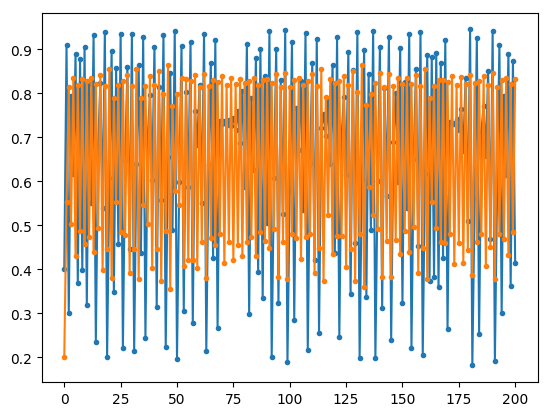

In [7]:
#reset plots
plt.cla()
plt.clf()
plt.close()
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(data_array[0,:],'.-')
plt.plot(data_array[1,:],'.-')

plt.show()

In [8]:
tmax = 5000
coupled_sys = coupled_equation(r_x, beta_xy, r_y,beta_yx)
data_array = coupled_sys.generate_data(tmax,x0)
E=3
tau=1

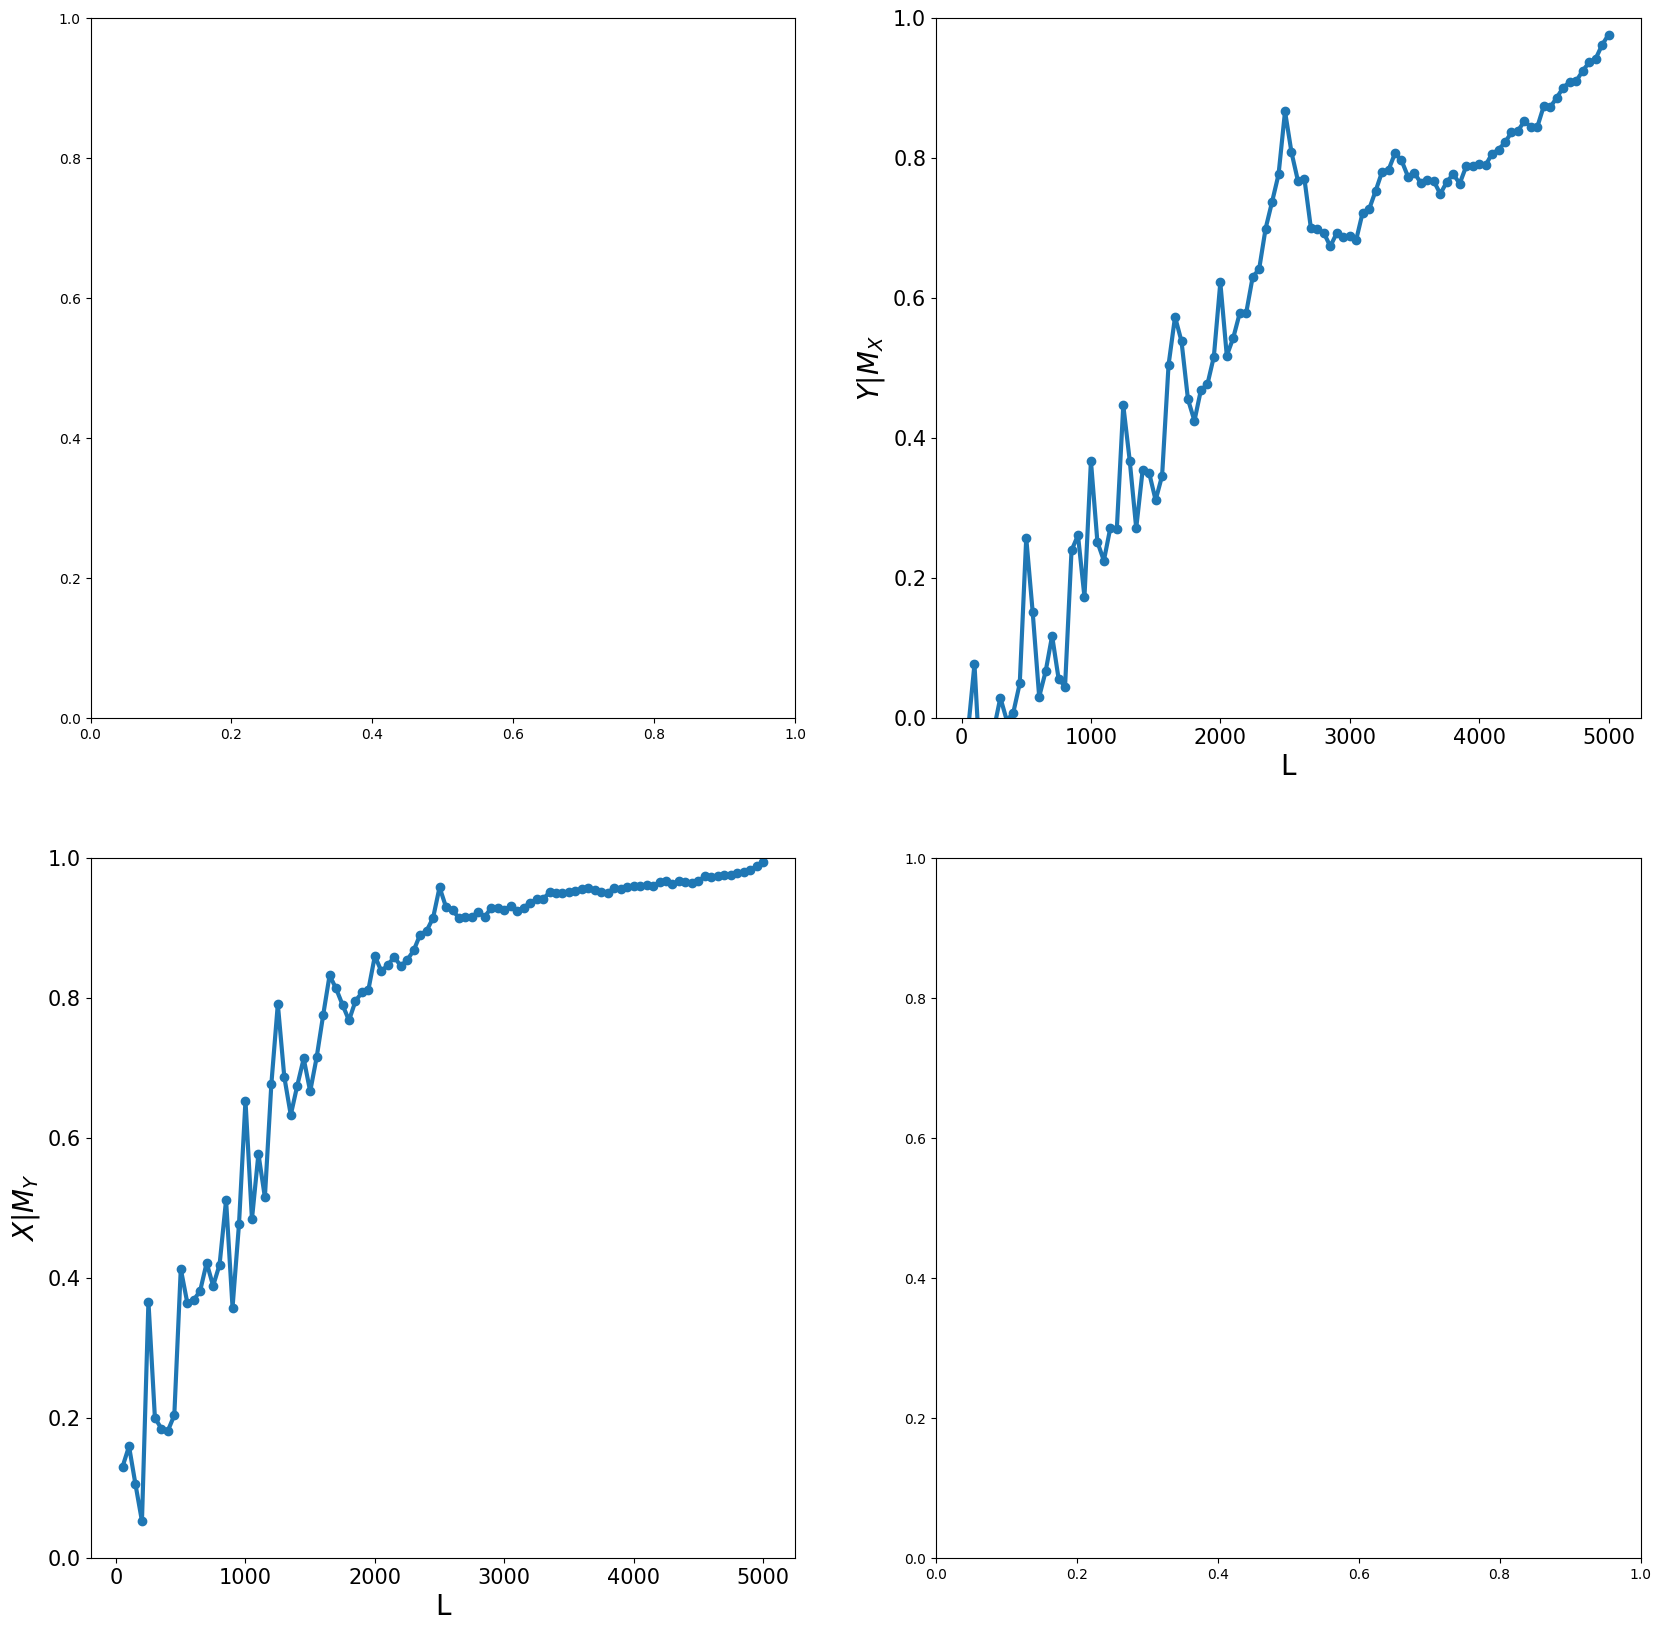

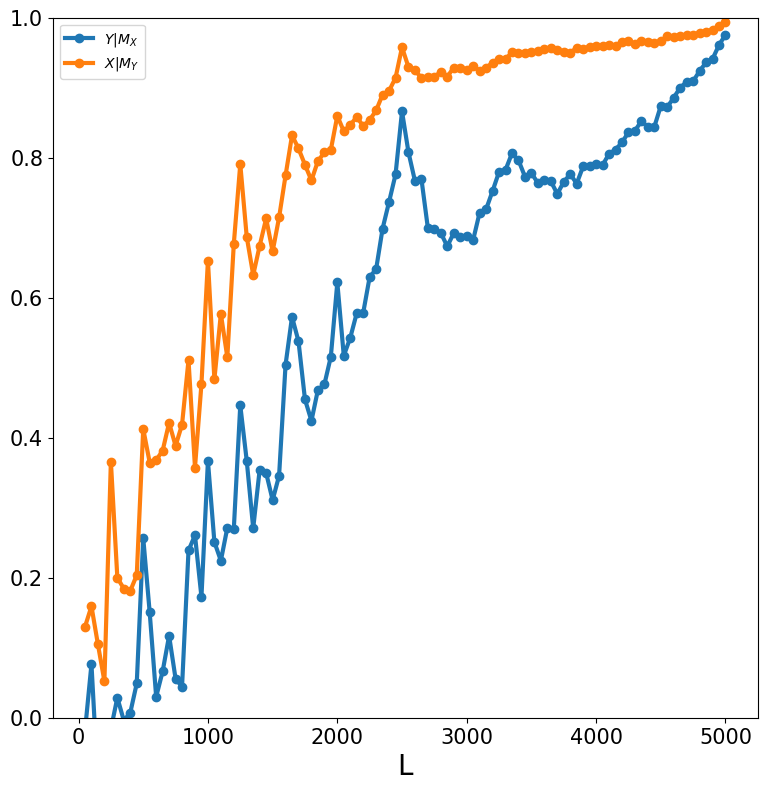

In [9]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [20,20]

names =  ['X','Y']
generate_multiple_correlation_plots(plt,data_array,E,tau,names,sample_size=50)

# Van der Pool Oscillator

## Causality between position to velocity of Van der Pool Oscillator

### Comparision of Velocity and CCM generated Velocity of Van der Pool Oscillator

In [ ]:
CCM_y1 = generate_convergent_cross_approx(sol.y[0,:],sol.y[1,:],E,tau)

#reset plt
plt.cla()
plt.clf()
plt.close()

#plot phase plane

plt.rcParams.update(plt.rcParamsDefault)
plt.plot(sol.y[0,(E-1)*tau:],sol.y[1,(E-1)*tau:],'-',linewidth=3.0)
plt.plot(sol.y[0,(E-1)*tau:],CCM_y1,':',linewidth=2.0)
plt.legend(['original dynamical system','cross convergent mapping'],loc="upper right")
plt.show()

### Comparision of Position and CCM generated Position of Van der Pool Oscillator

In [ ]:
CCM_y0 = generate_convergent_cross_approx(sol.y[1,:],sol.y[0,:],E,tau)

#reset plt
plt.cla()
plt.clf()
plt.close()

#plot phase plane
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(sol.y[0,(E-1)*tau:],sol.y[1,(E-1)*tau:],'-',linewidth=3.0)
plt.plot(CCM_y0,sol.y[1,(E-1)*tau:],':',linewidth=2.0)
plt.legend(['original dynamical system','cross convergent mapping'],loc="upper right")
plt.show()

### Predictability as a function Data length

Plot of predictability, as measure by correlation between CCM predictions and actual data, as a function of data length, L. The original input data was evenly and deterministicly sampled. 

In [ ]:
[L,rho_X,rho_Y] = generate_single_correlation_plot(sol.y[0,:],sol.y[1,:],E,tau)

#reset plt
plt.cla()
plt.clf()
plt.close()

#plot correlation as function of data length
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(L,rho_X,'-o')
plt.plot(L,rho_Y,'-o')
plt.legend(['$\hat{X}  | M_Y$', '$\hat{Y} | M_X$'],loc="upper right")
plt.show()

# Simple Enzymatic Reaction

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

S = np.array([[-1, 1, 0, 0, 0, 0],
              [ 0, 0, 0, 0, 1, -1],
              [ 1,-1,-1, 1, 0, 0],
              [ 0, 0, 1,-1,-1, 1],
              [-1, 1, 0, 0, 1,-1]])
reaction_rates =np.array([3.0,2.0,2.0,5.0,1.0,1.0])
tinit = 0.0
tmax = 10.0
dt = 0.01

x0 = np.array([1.0,1.0,1.0,1.0,1.0])

chemical_obj=dynamicalModels.enzymatic_reaction(S,reaction_rates)

sol = chemical_obj.integrate(tinit,tmax,dt,x0)
chemical_obj.evolution_plot()

## Phase plane plots

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol.y
names =  ['$[X_1]$','$[X_2]$',
            '$[X_1E_1]$','$[X_2E_1]$',
                    '$[E_1]$']

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
y = sol.y
names =  ['[X_1]','[X_2]', '[X_1E_1]','[X_2E_1]','[E_1]']
E=6
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Simple Enzymatic Reaction with Gillespie Sampling

In [ ]:
reaction_rates =np.array([3.0,2.0,2.0,5.0,1.0,1.0])
chemical_obj= dynamicalModels.enzymatic_reaction(S,reaction_rates)
sol = chemical_obj.solve_markov_process(tinit,20.0,np.array([100.0,20.0,20.0,20.0,100.0]))

In [ ]:
y = sol[1].T
total_len =y.shape[1]
idx = np.round(np.linspace(0, total_len-1,4000)).astype(int)
y = y[:,idx]

## Phase Plane Plots

In [ ]:
# parameters for generate_phase_plane_plots

plt.cla()
plt.clf()
plt.close()

# parameters for generate_phase_plane_plots
names =  ['$[X_1]$','$[X_2]$',
            '$[X_1E_1]$','$[X_2E_1]$',
                    '$[E_1]$']
plt.rcParams['figure.figsize'] = [30,30]

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
names =  ['[X_1]','[X_2]', '[X_1E_1]','[X_2E_1]','[E_1]']
E=6
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Wiener Process

Causation between 4 independently sampled Weiner Process

In [ ]:
def a_fun(X):
    return -2
def b_fun(X):
    return 5

#create four independently sample Weiner Process
sodes= dynamicalModels.sdes(a_fun,b_fun)
y = np.zeros([4,2000])
for i in range(4): 
    out = sodes.euler_maruyama(1.0,10.0,4.0,2000)
    y[i,:] = out[1]

## Phase Plane Plots

In [ ]:
# parameters for generate_phase_plane_plots

plt.cla()
plt.clf()
plt.close()

# parameters for generate_phase_plane_plots
names =  ['$X_1$','$X_2$',
            '$X_3$','$X_4$']
plt.rcParams['figure.figsize'] = [30,30]

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [40,40]

#parameters for generate_multiple_correlation_plots
names =  ['X_1','X_2','X_3','X_4']
E=5
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Kuramuto Models: Parameter Set I

In [ ]:
# these are our constants
N = 3  # number of variables
K = 10 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax = 20.0
dt =  0.01

In [ ]:
kuramoto = dynamicalModels.Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

## Phase Plots

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
idx = np.round(np.linspace(0, total_len-1,1000)).astype(int)
y = y[:,idx]
names =  ['$X_0$','$X_1$',
            '$X_2$',]

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['X_0','X_1', 'X_2','X_3']
E=4
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Kuramoto Model: II

In [ ]:
# these are our constants
N = 3  # number of variables
K = 2 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax = 40.0
dt =  0.01

In [ ]:
kuramoto = dynamicalModels.Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

## Phase Plots

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
idx = np.round(np.linspace(0, total_len-1,1000)).astype(int)
y = y[:,idx]
names =  ['$X_0$','$X_1$',
            '$X_2$']

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['X_0','X_1', 'X_2']
E=4
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Kuramoto Model: III

In [ ]:
# these are our constants
N = 3  # number of variables
K = 0.01 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax = 100.0
dt =  0.1

In [ ]:
kuramoto = dynamicalModels.Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

## Phase Plots

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
idx = np.round(np.linspace(0, total_len-1,1000)).astype(int)
y = y[:,idx]
names =  ['$X_0$','$X_1$',
            '$X_2$']

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['X_0','X_1', 'X_2']
E=4
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Kuramoto Model: IV (Spurious Correlation?)

In [ ]:
# these are our constants
N = 5 # number of variables
K = 0 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax =80.0
dt =  0.01

In [ ]:
kuramoto = dynamicalModels.Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

## Phase Plots

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol[1].T
total_len =y.shape[1]
idx = np.round(np.linspace(0, total_len-1,2000)).astype(int)
y = y[:,idx]
names =  ['$X_0$','$X_1$',
            '$X_2$','$X_3$','$X_4$']

generate_phase_plane_plots(plt,y,names)

## Correlation Plots

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['X_0','X_1', 'X_2','X_3','X_4']
E=6
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)

# Lorenz 96

In [ ]:
# these are our constants
N = 5  # number of variables
F = 8  # forcing
x0 = F*np.ones(N) # initial state (equilibrium)
x0[2] += 0.01 # add small perturbation to 20th variable
tinit = 0
tmax = 10.0
dt = 0.01

In [ ]:
lorenz96 = dynamicalModels.Lorenz96(N,F)
sol = lorenz96.integrate(tinit,tmax, dt ,x0)

In [ ]:
#reset plot 
plt.cla()
plt.clf()
plt.close()

plt.rcParams['figure.figsize'] = [30,30]

# generate_phase_plane_plots parameters
y = sol.y
names =  ['$X_1$','$X_2$',
            '$X_3$','$X_4$',
                    '$X_5$']

generate_phase_plane_plots(plt,y,names)

In [ ]:
#reset plots
plt.cla()
plt.clf()
plt.close()

#plot parameters
plt.rcParams['figure.figsize'] = [30,30]

#parameters for generate_multiple_correlation_plots
names =  ['X_1','X_2', 'X_3','X_4','X_5']
E=6
tau=1
generate_multiple_correlation_plots(plt,y,E,tau,names)